## Import the libraries

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Dense, Input,Flatten,Conv2D,Reshape,Conv2DTranspose

## Data Preprocessing

In [20]:
(train_images, _), (test_images, _) = fashion_mnist.load_data()

train_images = train_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255

train_images = train_images.reshape((train_images.shape[0], 28, 28, 1))
test_images = test_images.reshape((test_images.shape[0], 28, 28, 1))


print(train_images.shape)
print(test_images.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [21]:
noise_factor = 0.2
x_train_noisy = train_images + noise_factor * tf.random.normal(shape=train_images.shape)
x_test_noisy = test_images + noise_factor * tf.random.normal(shape=test_images.shape)

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

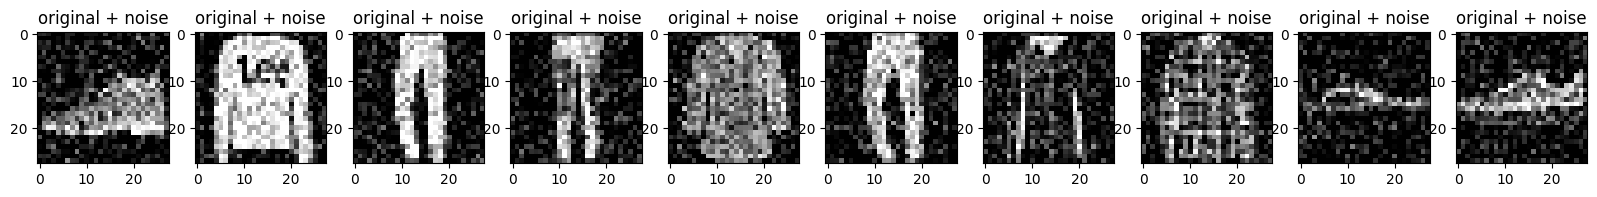

In [22]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

## AutoEncoder Model

In [65]:
class Denoise(Model):
    def __init__(self, latent_dim, shape):
        super(Denoise, self).__init__()
        self.latent_dim = latent_dim
        self.shape = shape

        # Encoder
        self.encoder = Sequential([
            Input(shape=(28, 28, 1)),
            Conv2D(32, (3, 3), activation='relu', strides=2, padding='same'),
            Conv2D(16, (3, 3), activation='relu', strides=2, padding='same'),
            Flatten(),
            Dense(latent_dim)
        ])

        # Decoder
        self.decoder = Sequential([
            Input(shape=(latent_dim,)),
            Dense(7*7*16,activation='relu'),
            Reshape((7,7,16)),
            Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
            Conv2DTranspose(32, kernel_size=3, strides=2, activation='relu', padding='same'),
            Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [66]:
model = Denoise(latent_dim=28,shape=(28,28,1))
model.compile(optimizer='adam',loss='mean_squared_error')
model.fit(x_train_noisy,train_images,epochs=10,batch_size=64,shuffle=True,validation_data=(x_test_noisy,test_images))

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 98s 102ms/step - loss: 0.0591 - val_loss: 0.0170
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 142s 102ms/step - loss: 0.0160 - val_loss: 0.0141
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 138s 99ms/step - loss: 0.0136 - val_loss: 0.0128
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 160s 118ms/step - loss: 0.0125 - val_loss: 0.0122
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 124s 98ms/step - loss: 0.0119 - val_loss: 0.0117
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 143s 100ms/step - loss: 0.0115 - val_loss: 0.0115
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 145s 103ms/step - loss: 0.0112 - val_loss: 0.0111
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 140s 101ms/step - loss: 0.0111 - val_loss: 0.0110
Epoch 9/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 96s 103ms/step - loss: 0.0109 - val_loss: 0.0108
Epoch 10/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 139s 99ms/step - loss: 0.0107 - val_loss: 0.0107


In [67]:
model.encoder.summary()

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_36 (Conv2D)                   │ (None, 14, 14, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_37 (Conv2D)                   │ (None, 7, 7, 16)            │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 28)                  │          21,980 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,924 (105.17 KB)

 Trainable params: 26,924 (105.17 KB)

 Non-trainable params: 0 (0.00 B)

In [68]:
model.decoder.summary()

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                      │ (None, 784)                 │          22,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_26                  │ (None, 14, 14, 16)          │           2,320 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_27                  │ (None, 28, 28, 32)          │           4,640 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_38 (Conv2D)                   │ (None, 28, 28, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,985 (117.13 KB)

 Trainable params: 29,985 (117.13 KB)

 Non-trainable params: 0 (0.00 B)

In [69]:
encoded_imgs = model.encoder(x_test_noisy).numpy()
decoded_imgs = model.decoder(encoded_imgs).numpy()

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step


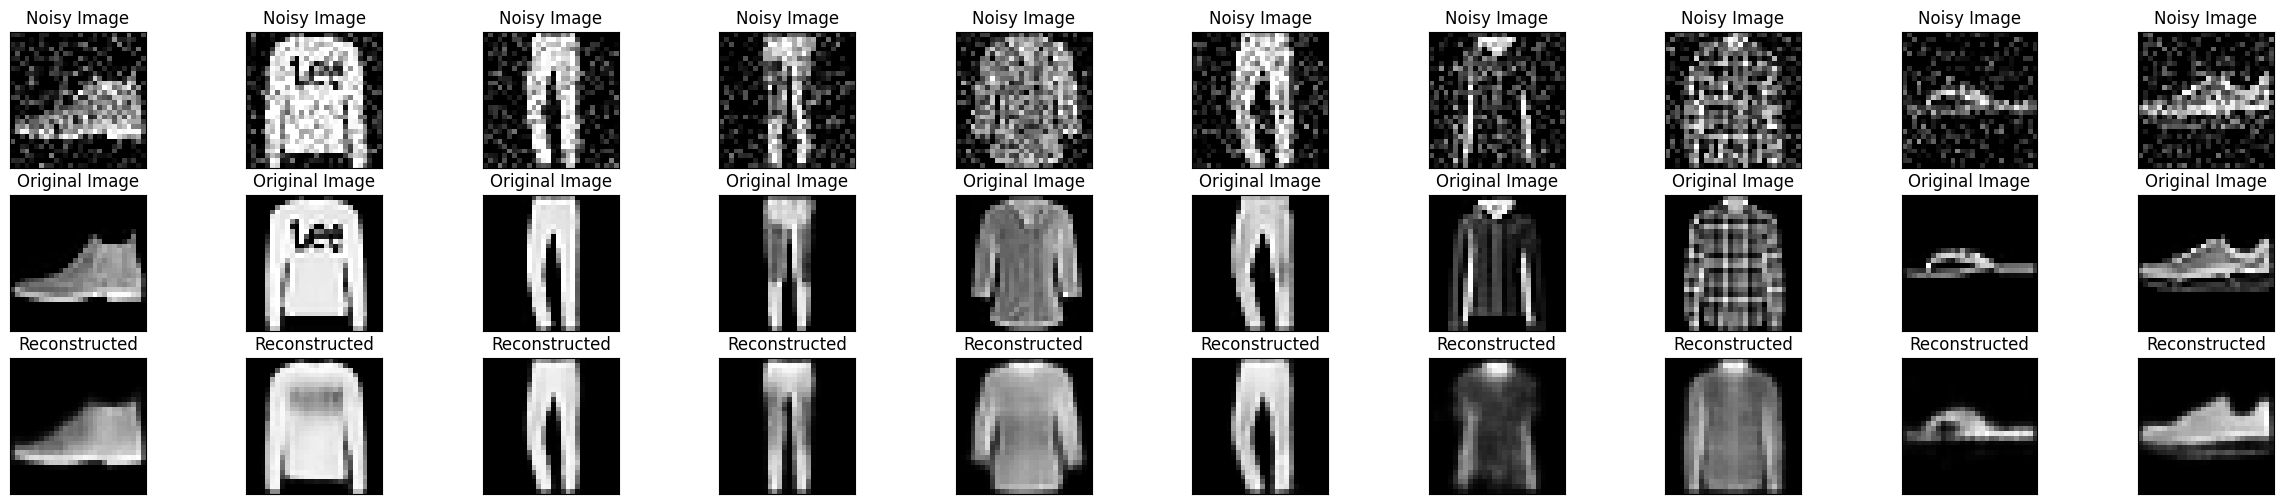

In [74]:
# Predict on the noisy test set
decoded_imgs = model.predict(x_test_noisy)

# Number of images to display
n = 10
plt.figure(figsize=(30, 6))

for i in range(n):
    # Plot original noisy images
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(tf.squeeze(x_test_noisy[i]), cmap='gray')
    plt.title("Noisy Image")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Plot original images
    bx = plt.subplot(3, n, i + n + 1)
    plt.imshow(tf.squeeze(test_images[i]), cmap='gray')
    plt.title("Original Image")
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)

    # Plot reconstructed images
    cx = plt.subplot(3, n, i + 2 * n + 1)
    plt.imshow(tf.squeeze(decoded_imgs[i]), cmap='gray')
    plt.title("Reconstructed")
    cx.get_xaxis().set_visible(False)
    cx.get_yaxis().set_visible(False)

plt.show()


In [72]:
# Evaluate the model on test data
test_loss = model.evaluate(x_test_noisy, test_images)
print(f"Test Loss: {test_loss:.4f}")

train_loss = model.evaluate(x_train_noisy, train_images)
print(f"Train Loss: {train_loss:.4f}")


313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0107
Test Loss: 0.0107
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - loss: 0.0105
Train Loss: 0.0105
